## Initial hierarchical analysis

In [1]:
#pip install cmdstanpy

In [2]:
#pip install -e git+https://github.com/stan-dev/cmdstanpy@develop#egg=cmdstanpy

In [17]:
import cmdstanpy as csp

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# for the loss functions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [164]:
data_all = pd.read_csv("data_mags_5000.csv")

In [165]:
data_all.columns

Index(['template_id', 'median_z', 'mean_z', 'minchi2', 'mode_z', 'z_sigma68',
       'z_sigma', 'z_mc'],
      dtype='object')

Read in all relevant data columns

In [4]:
# template data
group_id = data_all["template_id"] + 1 # + 1 since python and stan use different indices

# for redshift (less relevant)
median_z = data_all["median_z"]
z_sigma68 = data_all["z_sigma68"]
z_sigma = data_all["z_sigma"]
min_chi_z = data_all["minchi2"] # chi^2 of best fit template type

# galaxy properties
mag_sersic = data_all["mag_sersic_i"]
mag_cal = data_all["mag_cal_i"]
concentration = data_all['concentration_i']
asymmetry = data_all['asymmetry_i']
concentration = data_all['concentration_i']
clumpiness = data_all['clumpiness_i']
gini = data_all['gini_i']
m20 = data_all['m20_i']
re_sersic = data_all['re_sersic_i']
concentration = data_all['concentration_i']

Run the following relationships in the model (y vs x):

- `m20_i` vs magnitude
    - **Use as test dataset for determining priors, data cuts, and pooling amounts**
- Concentration vs magnitude
- Asymmetry vs magnitude
- Clumpiness vs magnitude
- `gini_i` vs magnitude
- Concentration vs `re_sersic_i`
- `gini_i` vs `m20_i` (? from paper)
- Magnitude vs z (unlikely but worth a shot)

In [149]:
# easy way to change the data to run on ONLY CHANGE IT HERE
x_data = min_chi_z
y_data = mag_sersic

# change labels for plots and accessing from dataframes
# NOTE: string must be the same as a column from data_all in order to access the dataframe later
x_label = "minchi2"
y_label = "mag_sersic_i"

# name the folder in the repo to save plots in. folder must exist already
folder_name = "saved-plots/"

In [150]:
# other prior information needed for the model
N = data_all.shape[0] # total number of objects

num_templates = len(np.unique(group_id))

a1 = 1
b1 = 1
a2 = 1
b2 = 1
nu = 3
lambda_var = 1

Not all templates may necessarily be represented in the choosen data set. Due to this, the number of templates may not necessarilly be as large as the maximum group_id value.

In [151]:
# collect data as input for the model into a single variable
data = {'N': N, 
        'J': num_templates,
        'm': np.max(group_id), 
        'y_data': y_data,
        'x_data': x_data,
        'group_id': group_id,
        'a1': a1,
        'b1': b1,
        'a2': a2,
        'b2': b2,
        'nu': nu,
        'lambda': lambda_var,}

In [152]:
#from cmdstanpy import install_cmdstan
#install_cmdstan(verbose=True)

In [153]:
model = csp.CmdStanModel(stan_file = 'hierarchical-regression.stan')
sample = model.sample(data = data, seed = 1, chains = 1,
                      iter_sampling = 1000, iter_warmup = 1000,
                      show_progress = False, show_console = False)

15:45:04 - cmdstanpy - INFO - CmdStan start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:19 - cmdstanpy - INFO - Chain [1] done processing


In [154]:
# how to save a model
# sample.save_csvfiles("second-run-sigma68/model-data-50000-prior1")

# how to read a saved file
#sample = csp.from_csv("model-data-cut-5000/hierarchical-regression-20240422121707.csv")

In [155]:
alpha_list = sample.stan_variable("alpha")
beta_list = sample.stan_variable("beta")

In [156]:
print(alpha_list.shape)

(1000, 44)


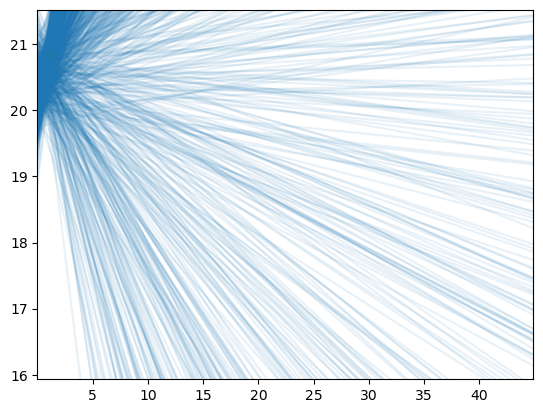

In [157]:
# plot all realizations of the generated lines from the model for a specific template type
# ignore this plot for now

group_index = 41

zs = np.arange(0, np.max(x_data), np.max(x_data)/1000)
segs = []
for i in range(alpha_list.shape[0]):
    data = alpha_list[i][group_index] + beta_list[i][group_index]*zs
    segs.append(((zs[0], data[0]), (zs[-1], data[-1])))

# get first group of data
group1_y = np.array(y_data)[np.where(group_id==group_index)]
group1_x = np.array(x_data)[np.where(group_id==group_index)]

#plot the group data
ln_coll = matplotlib.collections.LineCollection(segs, alpha=0.1)
ax = plt.gca()
ax2 = plt.scatter(group1_x, group1_y, color='orange')
ax.add_collection(ln_coll)
ax.set_xlim(np.min(x_data), np.max(x_data))    
ax.set_ylim(np.min(y_data), np.max(y_data))
plt.draw()

## Loss functions

In [158]:
# define additional loss function methods
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Plotting by template type
Group raw data by template ID and assign a color.

Make a line collection of all alphas and betas from each template group. Add in alpha_bar and beta_bar for a global linear fit.

In [159]:
alpha_group = np.array([np.mean(alpha_template) for alpha_template in sample.stan_variable("alpha").transpose()])
beta_group = np.array([np.mean(beta_template) for beta_template in sample.stan_variable("beta").transpose()])
color_map = np.arange(0, data_all["template_id"].max()+1)

In [160]:
# get the global slope and intercept
alpha_bar = np.mean(sample.stan_variable('alpha_bar'))
beta_bar = np.mean(sample.stan_variable('beta_bar'))
print(alpha_bar, beta_bar)

19.698546499999996 0.0639558912185


In [161]:
xs = np.arange(np.min(x_data), np.max(x_data), np.max(x_data)/1000)
segs = [] # for collection of lines to plot
masked_segs = [] # generate list of linear fits that pass the loss functions
masked_alphas = [] # list of alphas that pass loss funtions
masked_betas = [] # list of betas that pass loss functions
masked_x_data = []
masked_y_data = []
masked_group_id = []

for template_id in range(len(alpha_group)):
    subset = data_all[data_all['template_id']==template_id]
    
    data = alpha_group[template_id] + beta_group[template_id]*xs
    
    segs.append(((xs[0], data[0]), (xs[-1], data[-1])))

    if len(subset) < 10:
        continue

    predicted = alpha_group[template_id] + beta_group[template_id] * subset[x_label]
    
    # calculate loss functions
    mse_val = mean_squared_error(subset[y_label], predicted)
    r2_val = r2_score(subset[y_label], predicted)

    if (mse_val < 0.7) and (r2_val > 0.25):
        masked_segs.append(((xs[0], data[0]), (xs[-1], data[-1])))
        masked_alphas.append(alpha_group[template_id])
        masked_betas.append(beta_group[template_id])
        masked_x_data.extend(subset[x_label])
        masked_y_data.extend(subset[y_label])
        masked_group_id.extend(np.full(len(subset[x_label]), template_id))

# append the global linear fit as a single line, with all templates
global_seg = []
global_data = alpha_bar + beta_bar*xs
global_seg.append(((xs[0], global_data[0]), (xs[-1], global_data[-1])))

# append the global linear fit as a single line, with only good templates
masked_global_seg = []
masked_global_data = np.mean(masked_alphas) + np.mean(masked_betas)*xs
masked_global_seg.append(((xs[0], masked_global_data[0]), (xs[-1], masked_global_data[-1])))

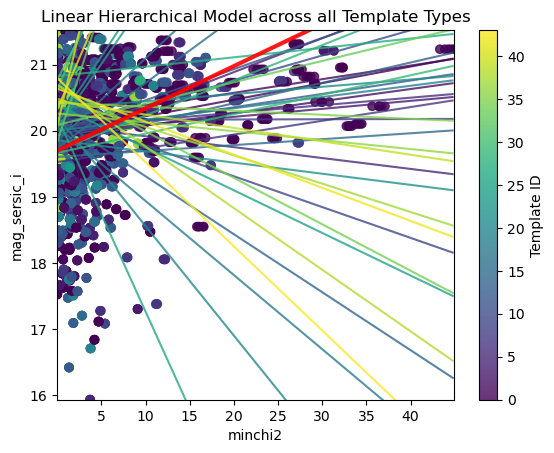

In [162]:
# plot all templates
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(x_data), np.max(x_data))    
ax.set_ylim(np.min(y_data), np.max(y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear Hierarchical Model across all Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(x_data, y_data, c=group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
fig.savefig(f"{folder_name}{y_label}_vs_{x_label}_all_data_plot.png", dpi=200)

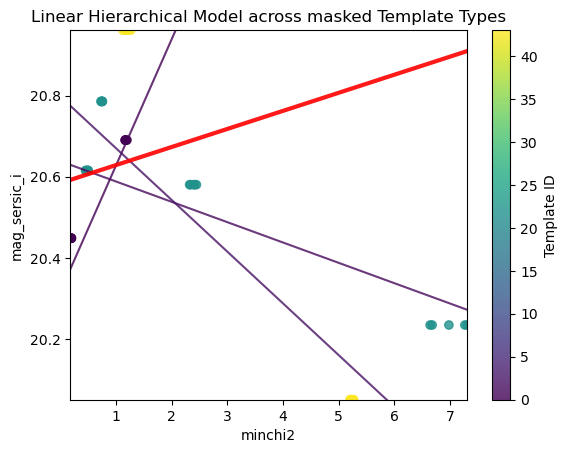

In [163]:
# only plot templates that pass the loss functions
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(masked_segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(masked_global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(masked_x_data), np.max(masked_x_data))    
ax.set_ylim(np.min(masked_y_data), np.max(masked_y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear Hierarchical Model across masked Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(masked_x_data, masked_y_data, c=masked_group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
fig.savefig(f"{folder_name}{y_label}_vs_{x_label}_mask_data_plot.png", dpi=200)

## Introducing magnitudes